In [1]:
import sys 
sys.path.append('..')
from src.swav import get_image_features, define_model, feature_dim
from src.build_classifier import get_classifier
from src.train_clf import train
# from src.clip import get_image_features, define_model, feature_dim 

In [2]:
sys.path.append('..')
from cifar.cifarRawCorrupted import get_original_loaders, get_corrupt_loaders

In [3]:

import matplotlib.pyplot as plt
import numpy as np
import torchvision.transforms.functional as FT
import torch

In [4]:


device='cuda:0'
dino_clf = get_classifier(2048, output_classes=10, n_layers=1).to(device)
train_loader, val_loader, test_loader = get_original_loaders(batch_size=1024, model_name='dino') 
test_corrupt_loader = get_corrupt_loaders(batch_size=1024, model_name='dino')

/home/omoussa/miniconda3/envs/brn/lib/python3.9/site-packages/torchvision/transforms/transforms.py:329: UserWarning: Argument 'interpolation' of type int is deprecated since 0.13 and will be removed in 0.15. Please use InterpolationMode enum.
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


In [5]:
c_loader = get_corrupt_loaders(model_name='dino', severity=1)

In [6]:
model = define_model(device=device, model_arc='dino_resnet50')

Using cache found in /home/omoussa/.cache/torch/hub/facebookresearch_dino_main
/home/omoussa/miniconda3/envs/brn/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/omoussa/miniconda3/envs/brn/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [7]:
loss_fn = torch.nn.CrossEntropyLoss()
optim = torch.optim.Adam(dino_clf.parameters(), lr=0.001)
n_epochs = 2

In [8]:
losses, accs, val_losses, val_accs = train(model, dino_clf, optim=optim, loss_fn=loss_fn,
                                           train_loader=train_loader, val_loader=val_loader,
                                           feature_fn=get_image_features, epochs=n_epochs, device=device) #TODO resize im in clip transforms

/home/omoussa/miniconda3/envs/brn/lib/python3.9/site-packages/torch/nn/modules/container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


initial loss 2.30228590965271 and initial accuracy 0.10872329771518707
 train loss: 1.8834792792797088, val loss: 1.6469696044921875, Train accuracy 0.6712646484375, val accuracy 0.8590142130851746 
 train loss: 1.6129861265420913, val loss: 1.5896903157234192, Train accuracy 0.8794921636581421, val accuracy 0.8929907083511353 


In [12]:
torch.save(dino_clf.state_dict(), '../saved_models/dino_clf_resnet_3ep.pth')


In [9]:
def get_acc(gt, preds = None):
    if preds is not None: 
        return ((preds.argmax(1)==gt).sum()/len(preds)).cpu().numpy()
        
    
    return ((preds.argmax(1)==gt).sum()/len(preds)).cpu().numpy()
    

def get_test_acc(emb_model, model, test_loader, feature_fn, device='cuda'):
    eval_acc = []
    eval_losses = []
    for eval_batch in test_loader:
        if len(eval_batch)>2:
            _, ims, labels = eval_batch
        else: 
            ims, labels = eval_batch
        ims, labels = ims.to(device), labels.to(device)
        with torch.no_grad():
            features = feature_fn(emb_model, ims).squeeze()
            preds = model(features)
            val_acc = get_acc(labels.view(-1,), preds)
        
        eval_acc.append(val_acc)
    
    return np.mean(eval_acc)
            # 
test_acc_orig = racc =  get_test_acc(model, dino_clf, test_loader, get_image_features, device=device,)
 


In [10]:
test_acc_orig

0.88894093

In [13]:
corrupts_dict = {}
corrupt_g_acc = []
for cr in ['gaussian_noise', 'speckle_noise', 'impulse_noise', 'shot_noise', ]:
    corrupts_dict[cr] = {}
    for sev in [1, 2, 3, 4, 5]:
        test_loader_corrupt = get_corrupt_loaders(batch_size=1024, corruption_type=cr, severity=sev, model_name='dino')
        acc =  get_test_acc(model, dino_clf, test_loader_corrupt, get_image_features, device=device,)
                                

        corrupts_dict[cr][sev]=acc
    print(corrupts_dict)

{'gaussian_noise': {1: 0.6488939, 2: 0.45807356, 3: 0.3242028, 4: 0.27981108, 5: 0.24524474}}
{'gaussian_noise': {1: 0.6488939, 2: 0.45807356, 3: 0.3242028, 4: 0.27981108, 5: 0.24524474}, 'speckle_noise': {1: 0.72471106, 2: 0.5816167, 3: 0.5293766, 4: 0.4516801, 5: 0.38674664}}
{'gaussian_noise': {1: 0.6488939, 2: 0.45807356, 3: 0.3242028, 4: 0.27981108, 5: 0.24524474}, 'speckle_noise': {1: 0.72471106, 2: 0.5816167, 3: 0.5293766, 4: 0.4516801, 5: 0.38674664}, 'impulse_noise': {1: 0.7182418, 2: 0.5061065, 3: 0.38377312, 4: 0.3090661, 5: 0.28151107}}
{'gaussian_noise': {1: 0.6488939, 2: 0.45807356, 3: 0.3242028, 4: 0.27981108, 5: 0.24524474}, 'speckle_noise': {1: 0.72471106, 2: 0.5816167, 3: 0.5293766, 4: 0.4516801, 5: 0.38674664}, 'impulse_noise': {1: 0.7182418, 2: 0.5061065, 3: 0.38377312, 4: 0.3090661, 5: 0.28151107}, 'shot_noise': {1: 0.7219906, 2: 0.61177456, 3: 0.4342993, 4: 0.38289422, 5: 0.30968192}}


In [18]:
corrupts_dict

{'gaussian_noise': {1: 0.6488939,
  2: 0.45807356,
  3: 0.3242028,
  4: 0.27981108,
  5: 0.24524474},
 'speckle_noise': {1: 0.72471106,
  2: 0.5816167,
  3: 0.5293766,
  4: 0.4516801,
  5: 0.38674664},
 'impulse_noise': {1: 0.7182418,
  2: 0.5061065,
  3: 0.38377312,
  4: 0.3090661,
  5: 0.28151107},
 'shot_noise': {1: 0.7219906,
  2: 0.61177456,
  3: 0.4342993,
  4: 0.38289422,
  5: 0.30968192}}

In [ ]:
corrupts_dict #resnet

{'gaussian_noise': {1: 0.6325654,
  2: 0.53554887,
  3: 0.46369776,
  4: 0.43698978,
  5: 0.4114577},
 'speckle_noise': {1: 0.6852838,
  2: 0.59790736,
  3: 0.5672772,
  4: 0.49300462,
  5: 0.42747927},
 'impulse_noise': {1: 0.72118545,
  2: 0.6653938,
  3: 0.6129743,
  4: 0.52856344,
  5: 0.45756936},
 'shot_noise': {1: 0.6846381, 2: 0.626132, 3: 0.52573144}}

In [305]:
corrupts_dict

{'gaussian_noise': {1: 0.73811185,
  2: 0.5256258,
  3: 0.3595384,
  4: 0.2969647,
  5: 0.25609854},
 'speckle_noise': {1: 0.82182914,
  2: 0.6371293,
  3: 0.5495516,
  4: 0.39626914,
  5: 0.29803294},
 'impulse_noise': {1: 0.8388193,
  2: 0.72830236,
  3: 0.60020727,
  4: 0.4025271,
  5: 0.28812978},
 'shot_noise': {1: 0.8187281,
  2: 0.7007035,
  3: 0.44766623,
  4: 0.3658263,
  5: 0.26989597}}

## Test imgs from dataset

In [7]:
m, s = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

In [8]:
den = (u[-3]*torch.tensor(s)[:, None, None])+torch.tensor(m)[:, None, None]

In [151]:
device = 'cuda:0'

In [265]:
im_features = get_image_features(model, im_batch[0].to(device))

In [239]:
sample = torch.randn(1, 3, 224, 224)

In [240]:
torch.cat([torch.rand(5,2), torch.rand(5, 2)]).shape

torch.Size([10, 2])

In [33]:
model = torch.hub.load('facebookresearch/swav:main', 'resnet50').to(device)

Using cache found in /home/omoussa/.cache/torch/hub/facebookresearch_swav_main
/home/omoussa/miniconda3/envs/brn/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/omoussa/miniconda3/envs/brn/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [34]:
model = model.eval()

In [39]:
modules=list(model.children())[:-1]
mod = torch.nn.Sequential(*modules).eval()
for p in mod.parameters():
    p.requires_grad = False



In [40]:
mod

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)


In [42]:
mod(next(iter(c_loader))[0].to(device)).shape

torch.Size([64, 2048, 1, 1])

## KNN Test

In [266]:
def extract_ds_features(model, data_loader, get_features_fn,  device):
    feature_list, labels_list = [], []
    for batch in data_loader: 
        img_tensor, labels = batch[0].to(device), batch[1].to(device)
        feature_tensor = get_features_fn(model, img_tensor)
        feature_list.append(feature_tensor)
        labels_list.append(labels)
    
    all_features_tensor = torch.cat(feature_list)
    all_labels_tensor = torch.cat(labels_list)

    return all_features_tensor, all_labels_tensor
    
    

In [267]:
features_tensor, labels_tensor = extract_ds_features(model, c_loader, get_image_features, device=device)

In [167]:
u, c = np.unique((labels_tensor.cpu().numpy()), return_counts=True)

<BarContainer object of 10 artists>

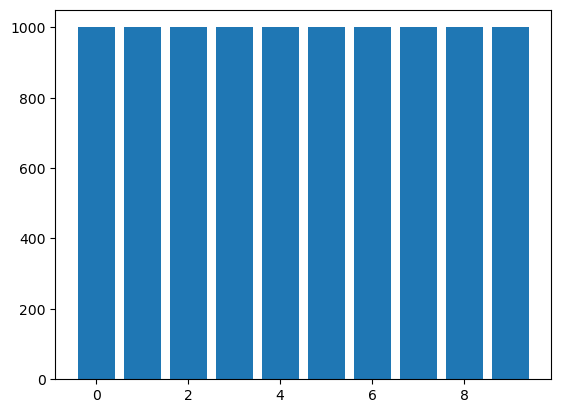

In [168]:
plt.bar(u,c)

In [169]:
import torch.nn.functional as F

In [283]:
@torch.no_grad()
def knn_classifier(train_features, train_labels, test_features, test_labels, k, T=0.007, num_classes=10):
    top1, top5, total = 0.0, 0.0, 0
    train_features = train_features.t()
    print(train_features.shape)
    num_test_images, num_chunks = test_labels.shape[0], 100
    imgs_per_chunk = num_test_images // num_chunks
    retrieval_one_hot = torch.zeros(k, num_classes).to(torch.int64).to(train_features.device)
    all_idxs = torch.arange(test_labels.shape[0])
    for idx in range(0, num_test_images, imgs_per_chunk):
        # get the features for test images
        si, ei =  idx, min((idx + imgs_per_chunk), num_test_images)
        ixs = (torch.arange(si, ei))
        # mask = all_idxs[all_idxs!=ixs]
        index = torch.ones(all_idxs.shape[0], dtype=bool)
        index[ixs] = False
        selected_ixx = all_idxs[index]
        # print(selected_ixx)
        features = test_features[ixs]
        # print(features.shape)
        targets = test_labels[ixs]
        batch_size = targets.shape[0]
        # print(train_features[selected_ixx].shape)
        train_features_f = train_features
        # calculate the dot product and compute top-k neighbors
        similarity = torch.mm(features, train_features_f)
        distances, indices = similarity.topk(k+1, largest=True, sorted=True)
        distances, indices = distances[:, 1:], indices[:, 1:]
        # print(distances.shape, indices.shape)
        candidates = train_labels.view(1, -1).expand(batch_size, -1)
        retrieved_neighbors = torch.gather(candidates, 1, indices).to(torch.int64)

        retrieval_one_hot.resize_(batch_size * k, num_classes).zero_()
        retrieval_one_hot.scatter_(1, retrieved_neighbors.view(-1, 1), 1)
        # print(torch.mode(retrieved_neighbors).values, targets)
        # print(targets)
        # print(retrieval_one_hot.argmax(1))
        # print((torch.min(distances, dim=1)).values.shape)
        distances_transform = F.softmax(distances)
        probs = torch.sum(
            torch.mul(
                retrieval_one_hot.view(batch_size, -1, num_classes),
                distances_transform.view(batch_size, -1, 1),
            ),
            1,
        )
        # print(probs)
        _, predictions = probs.sort(1, True) #torch.mode(retrieved_neighbors).values#probs.sort(1, True)
    
        # find the predictions that match the target
        correct = predictions.eq(targets.data.view(-1, 1))
        # print(correct.narrow(1, 0, 1).sum().item())
        top1 = top1 + correct.narrow(1, 0, 1).sum().item() #(predictions==targets).sum().item() #correct.narrow(1, 0, 1).sum().item()
        top5 = top5 + correct.narrow(1, 0, min(5, k)).sum().item()  # top5 does not make sense if k < 5
        total += targets.size(0)
    top1 = top1 * 100.0 / total
    top5 = top5 * 100.0 / total
    return top1, top5

In [284]:
t1 = knn_classifier(features_tensor, labels_tensor, features_tensor, labels_tensor, k=5)

torch.Size([512, 10000])
tensor([[128.9912, 102.5153, 110.9711,  ..., 121.5298, 112.4859, 109.7766],
        [102.5153, 117.6194, 105.6119,  ..., 105.3208, 105.1251,  95.6393],
        [110.9711, 105.6119, 119.3399,  ..., 113.0804, 111.4680, 105.0500],
        ...,
        [ 93.5001,  92.7817,  90.8941,  ...,  96.5368,  92.6052,  89.2044],
        [ 95.0493,  95.0555,  90.5026,  ...,  97.0975, 100.0976,  87.0464],
        [117.6388, 106.2873, 112.1058,  ..., 119.0548, 112.0519, 116.3350]],
       device='cuda:0')
tensor([[109.6027,  95.9793, 101.6505,  ..., 107.8177, 102.1275, 108.4063],
        [113.4085,  94.1812, 103.5155,  ..., 112.3861, 103.8384, 103.4762],
        [111.7366,  99.0543, 103.8617,  ..., 113.9273, 107.3911,  98.4364],
        ...,
        [105.5956,  98.9894, 104.6123,  ..., 114.6260, 103.2934,  97.9026],
        [115.2993, 101.1483, 106.8330,  ..., 115.4244, 108.7709, 115.3206],
        [109.3256, 106.6275, 107.8506,  ..., 111.7719, 105.9930,  98.1649]],
       devi

/tmp/ipykernel_478488/1081338173.py:40: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  distances_transform = F.softmax(distances)


tensor([[114.7154, 100.1342, 107.6370,  ..., 115.3252, 110.1722, 106.6187],
        [113.7112,  97.7675, 102.2955,  ..., 108.0356, 106.2376, 105.5721],
        [113.5792,  98.1455, 106.2695,  ..., 118.3633, 106.3147, 101.9429],
        ...,
        [122.6199, 100.8569, 108.9384,  ..., 118.0847, 110.2245, 109.4510],
        [ 98.5839,  99.0410, 101.4301,  ..., 100.4992, 101.8618,  97.0953],
        [120.4904, 100.7563, 108.1281,  ..., 117.7065, 106.4951, 106.5041]],
       device='cuda:0')
tensor([[111.1811, 108.2878, 110.9687,  ..., 112.5745, 108.6423, 102.3146],
        [108.0401,  99.7125, 108.4902,  ..., 108.2913, 109.2739, 100.3056],
        [117.8842,  99.2855, 105.8448,  ..., 116.8252, 107.7436, 105.1985],
        ...,
        [ 98.1529,  94.4115,  96.1933,  ..., 100.9855,  98.5000,  91.2989],
        [123.3041, 102.2724, 109.0195,  ..., 119.6805, 112.7579, 109.5524],
        [104.4661, 101.3414, 107.7782,  ..., 103.3702, 104.7159,  98.1776]],
       device='cuda:0')
tensor([[109

In [270]:
t1

(70.65, 91.07)

In [273]:
t1

(70.78, 0.0)